# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np

data_base_path = os.path.join(os.pardir, '..\data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

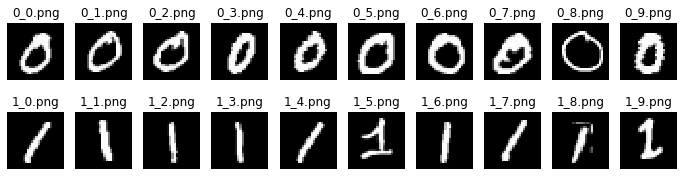

In [2]:
import skimage.io
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, '..\data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [3]:
def make_binary(im, l, u):
    
    tp = im.copy()
    
    tp[tp < l] = 0
    tp[tp > u] = 0
    tp[tp != 0] = 1
    
    return tp

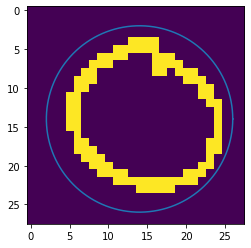

In [5]:
z = zeros_im[8]
z = make_binary(z, 122, 255)
z[z==1] = 255

## Create init snake and verify

s = np.linspace(0, 2*np.pi, 400)
x = 14 + 12*np.cos(s)
y = 14 + 12*np.sin(s)
init = np.array([x, y]).T

plt.imshow(z)
plt.plot(init[:,0], init[:,1])

plt.show()

In [6]:
import cv2

In [7]:
from skimage.segmentation import active_contour

## Tune grid and snake

In [8]:
im = ones_im[6]
im = make_binary(im, 122, 255)
im[im == 1] = 255
snake = active_contour(cv2.GaussianBlur(im, (3,3), 1), init, alpha=1, beta=100, gamma=0.15, w_line=-0.1, coordinates='rc') 

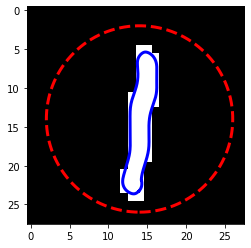

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
plt.show()

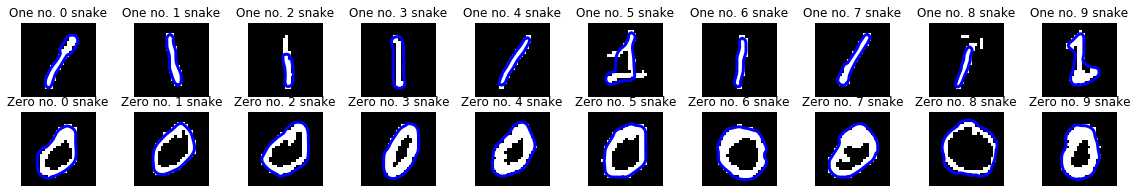

In [10]:
import cmath

fig, ax = plt.subplots(2, len(zeros_im), figsize=(20,3))

ones_a1 = []
ones_a2 = []

for i, one in enumerate(ones_im):

    im = make_binary(one, 122, 255)
    im[im == 1] = 255
    snake = active_contour(cv2.GaussianBlur(im, (3,3), 1), init, alpha=1, beta=100, gamma=0.15, w_line=-0.1, coordinates='rc')   
    complex_coords = [complex(xi, yi) for xi, yi in snake]
    
    ax[0, i].imshow(im, cmap=plt.cm.gray)
    ax[0, i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[0, i].axis('off')
    ax[0, i].set_title(f'One no. {i} snake')

    f_trans = np.fft.fft(complex_coords)[1:3]
    amps = np.abs(f_trans)
    amps[1:]/=amps[0]
    ones_a1.append(amps[0])
    ones_a2.append(amps[1])

    
zeros_a1 = []
zeros_a2 = []

for i, z in enumerate(zeros_im):
    
    im = make_binary(z, 122, 255)
    im[im == 1] = 255
    snake = active_contour(cv2.GaussianBlur(im, (3,3), 1), init, alpha=1, beta=100, gamma=0.15, w_line=-0.1, coordinates='rc')    
    complex_coords = [complex(xi, yi) for xi, yi in snake] 
    
    ax[1, i].imshow(im, cmap=plt.cm.gray)
    ax[1, i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[1, i].set_title(f'Zero no. {i} snake')

    ax[1, i].axis('off')
    
    f_trans = np.fft.fft(complex_coords)[1:3]
    amps = np.abs(f_trans)
    amps[1:]/=amps[0]
    zeros_a1.append(amps[0])
    zeros_a2.append(amps[1])

In [13]:
def scatter_ax(ax, x_s, y_s, xy_names, ann_shorthands, ann_on=True):
    
    n_classes = len(x_s)
    shorthands = [[ann+str(j) for j in range(len(x_s[i]))] for i, ann in enumerate(ann_shorthands)]
    
    for i in range(n_classes):
        ax.scatter(x_s[i], y_s[i])

    if ann_on:
        for i, s in enumerate(shorthands):
            for j, sj in enumerate(s): ax.annotate(sj, (x_s[i][j], y_s[i][j]))
                                               
    ax.set_xlabel(xy_names[0])
    ax.set_ylabel(xy_names[1])
    
    return ax

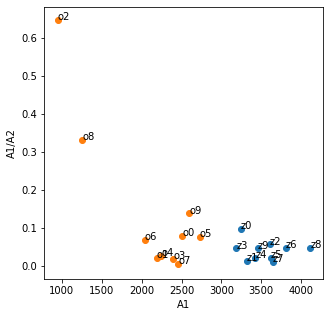

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax = scatter_ax(ax, (zeros_a1, ones_a1), (zeros_a2, ones_a2), ('A1', 'A1/A2'), ('z','o'))

plt.show()

### 1.3 Additional method(s)
Add your implementation and discussion

# 2

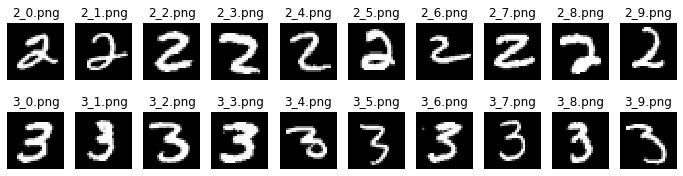

In [12]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

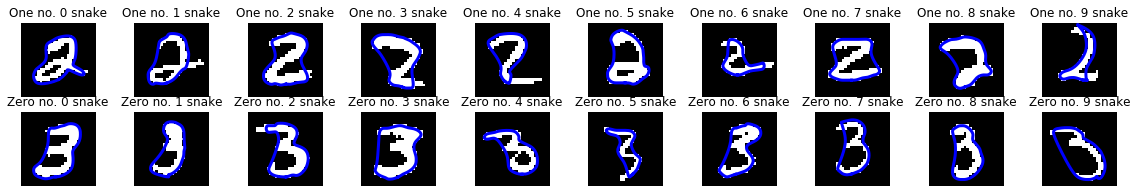

In [15]:
import cmath

fig, ax = plt.subplots(2, len(twos_im), figsize=(20,3))

twos_a1 = []
twos_a2 = []

for i, two in enumerate(twos_im):

    im = make_binary(two, 122, 255)
    im[im == 1] = 255
    snake = active_contour(cv2.GaussianBlur(im, (3,3), 1), init, alpha=1, beta=100, gamma=0.15, w_line=-0.1, coordinates='rc')   
    complex_coords = [complex(xi, yi) for xi, yi in snake]
    
    ax[0, i].imshow(im, cmap=plt.cm.gray)
    ax[0, i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[0, i].axis('off')
    ax[0, i].set_title(f'One no. {i} snake')

    f_trans = np.fft.fft(complex_coords)[1:3]
    amps = np.abs(f_trans)
    amps[1:]/=amps[0]
    twos_a1.append(amps[0])
    twos_a2.append(amps[1])

    
threes_a1 = []
threes_a2 = []

for i, three in enumerate(threes_im):
    
    im = make_binary(three, 122, 255)
    im[im == 1] = 255
    snake = active_contour(cv2.GaussianBlur(im, (3,3), 1), init, alpha=1, beta=100, gamma=0.15, w_line=-0.1, coordinates='rc')    
    complex_coords = [complex(xi, yi) for xi, yi in snake] 
    
    ax[1, i].imshow(im, cmap=plt.cm.gray)
    ax[1, i].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[1, i].set_title(f'Zero no. {i} snake')

    ax[1, i].axis('off')
    
    f_trans = np.fft.fft(complex_coords)[1:3]
    amps = np.abs(f_trans)
    amps[1:]/=amps[0]
    threes_a1.append(amps[0])
    threes_a2.append(amps[1])

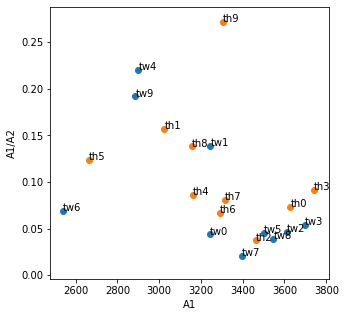

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax = scatter_ax(ax, (twos_a1, threes_a1), (twos_a2, threes_a2), ('A1', 'A1/A2'), ('tw','th'))

plt.show()

In [17]:
def is_pixel_set(im, pix):
    'Helper fn to freeman_path'
    
    return np.all(list(map(lambda x, y: x<y, pix, im.shape))) and im[pix]

In [23]:
from operator import add

def freeman_path(binary_im, x_init_offset=0, diagonals=True):

    x_max, y_max = binary_im.shape
    
    'Initialize search for boundary'
    x, y = x_max//2 + x_init_offset, 0

    'Find the first set pixel of the boundary'
    while not is_pixel_set(binary_im, (x,y)):
        y+=1
        assert y < y_max-1, f'No border found at x={x}'
    
    'Cardinal directions and their Freeman values'
    E, NE, N, NW, W, SW, S, SE = [i for i in range(8)]
    
    dirs = [E, NE, N, NW, W, SW, S, SE]

    'These are the dirs used when discovering new feasible paths'
    dirs_in_use = dirs    
    if not diagonals: dirs_in_use = [E, W, N, S]
    
    'Maps a cardinal direction to its pixel increment'
    dir_delta_map = {
        E: (1,0),
        NE: (1,1),
        N: (0,1),
        NW: (-1,1),
        W: (-1,0),
        SW: (-1,-1),
        S: (0,-1),
        SE: (1,-1)
    }
    
   
    'Init points. If we reach these again, the circle has been closed'
    x_init, y_init = x, y
    
    'Keep track of previously visited pixels to avoid loops'
    visited = []

    'If a path leads to a dead end, appropriate pixels are held responsible'
    failed_visits = set()
    
    
    'Initialize direction'
    current_dir = dirs_in_use[0]
    next_dir = current_dir
    
    encoded_path = []
    
    it = 0

    while it < 10000:
        
        it += 1
        
        'Set this if we find a feasible path away from current pixel'
        found_next_step = False

        'Been here, done that. Current pixel is added to path'
        visited.append((x,y))

        '...can we continue to move in our current direction?'
        coord_candidate = tuple(map(add, (x,y), dir_delta_map[current_dir]))
        
        if is_pixel_set(binary_im, coord_candidate) and coord_candidate not in failed_visits:
            encoded_path.append(next_dir)
            found_next_step = True
            
        else:
            for next_dir in dirs_in_use:
                if next_dir == current_dir: continue

                coord_candidate = tuple(map(add, (x,y), dir_delta_map[next_dir]))
                if coord_candidate in visited or coord_candidate in failed_visits: continue

                if is_pixel_set(binary_im, coord_candidate):
                    encoded_path.append(next_dir)
                    found_next_step = True
                    break
         
        if coord_candidate==(x_init, y_init):
            'Circle is closed. Head out'
            return x_init, y_init, np.array(encoded_path), np.array(visited)
           

        elif found_next_step:
            'Found new step, incrementing code and moving on'
            x, y = coord_candidate
            current_dir = next_dir 
            
        else:
            'We have reached a dead end!'

            try:
                'Try to go back one step and blacklist this pixel'
                failed_visits.add((x,y))
                
                x, y = visited[-2]
                visited = visited[:-2]
                
                current_dir = dirs[encoded_path[-2]]
                encoded_path = encoded_path[:-1]
                
            except:
                'Algorithm fails early (visited[-2] does not exist)'
                'Alter init slightly and run algorithm again'
                return freeman_path(binary_im, x_init_offset=x_init_offset+1, diagonals=diagonals)
            
    print('freeman_path FAILED')
    return x_init, y_init, encoded_path, visited

In [24]:
def restore_im_from_freeman_code(freeman_code, x_init, y_init, shape):
    
    E, NE, N, NW, W, SW, S, SE = [i for i in range(8)]

    directions = [E, NE, N, NW, W, SW, S, SE]
     
    'Maps a direction to their increments in x- and y values'
    dir_delta_map = {
        E: (1,0),
        NE: (1,1),
        N: (0,1),
        NW: (-1,1),
        W: (-1,0),
        SW: (-1,-1),
        S: (0,-1),
        SE: (1,-1)
    }
    
    im = np.zeros(shape)
    
    x, y = x_init, y_init
    
    coord = (x, y)
    
    im[coord] = 1
    
    for f in freeman_code:
        d = directions[f]
        coord = tuple(map(add, coord, dir_delta_map[d]))
        im[coord] = 1
        
    return im

In [25]:
def restore_im_from_coords(shape, coords):
    im = np.zeros(shape)
    for c in coords: im[c] = 1
    return im

In [21]:
im = zeros_im[9]
im_b = make_binary(im, 200, 255)
kernel = np.ones((3,3))
dil = cv2.dilate(im_b, kernel)
im_bord = dil-im_b

x,y,f,coords = freeman_path(im_bord, diagonals=False)
im_restored = restore_im_from_freeman_code(f, x, y, im_b.shape)

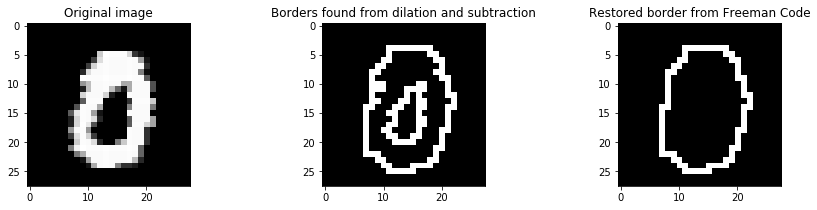

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(im_bord, cmap='gray')
ax[1].set_title('Borders found from dilation and subtraction')
ax[2].imshow(im_restored, cmap='gray')
ax[2].set_title('Restored border from Freeman Code')
plt.show()

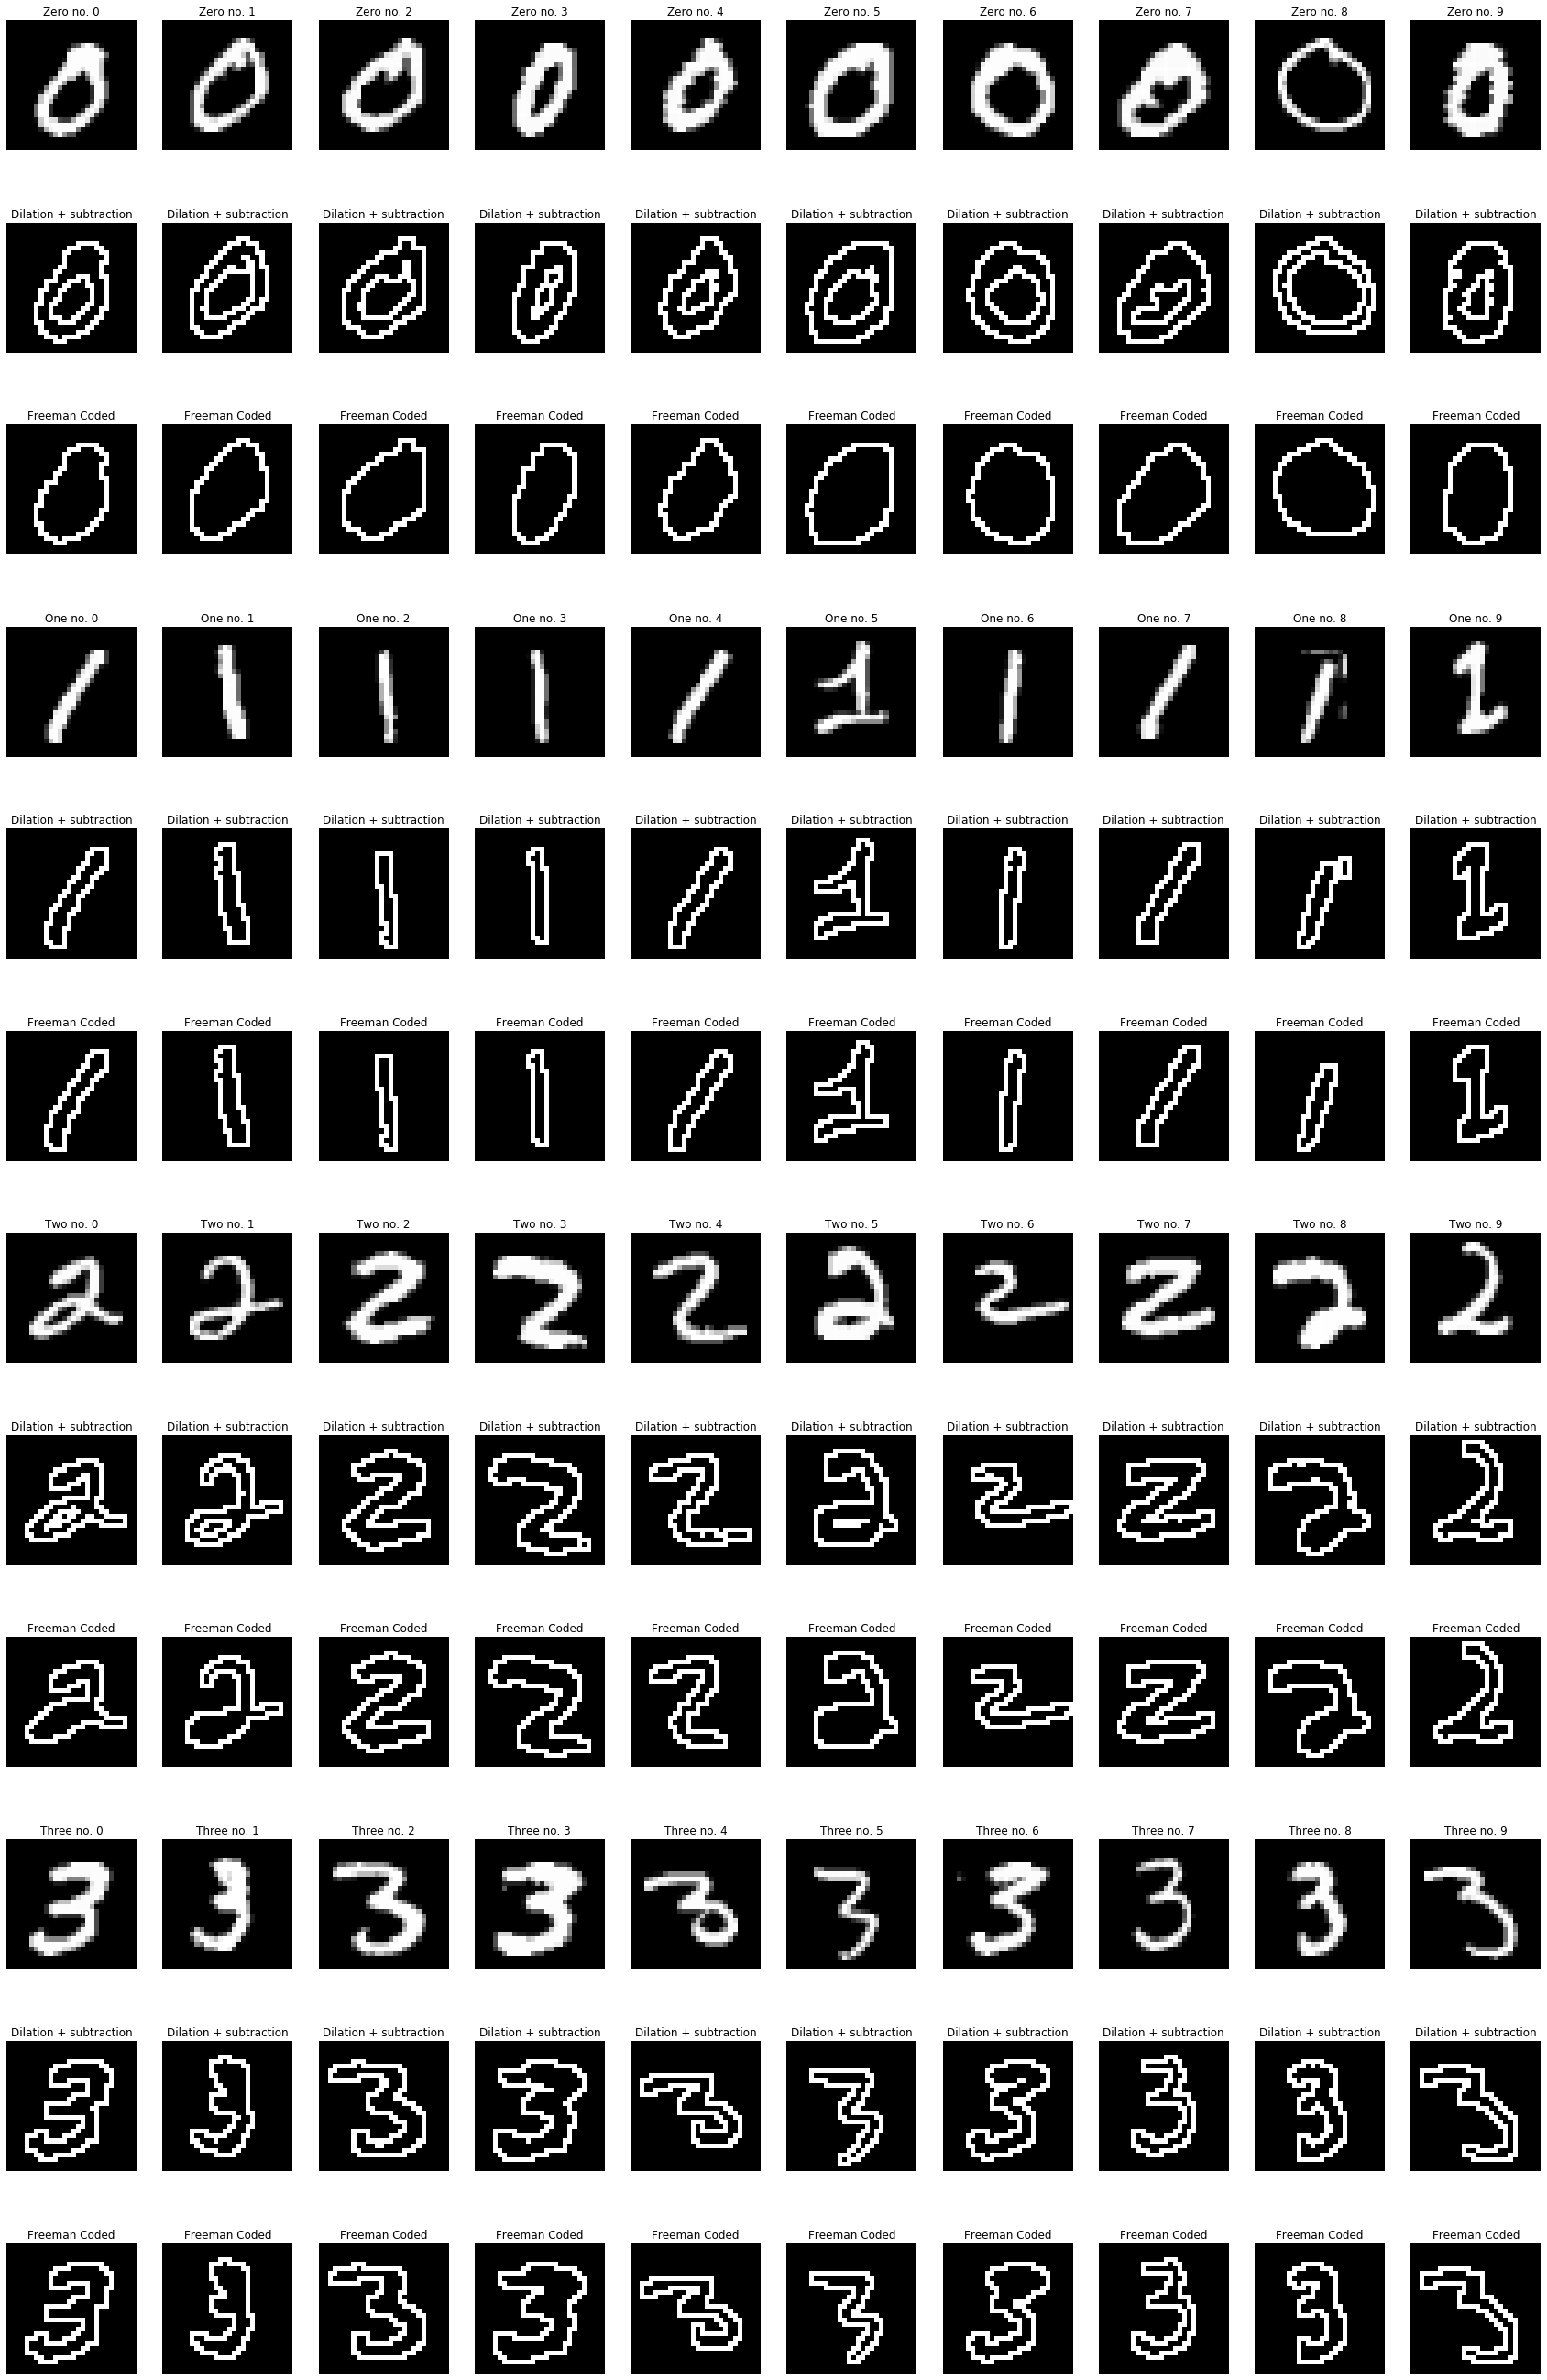

In [26]:
fig, ax = plt.subplots(12, 10, figsize=(10*3,4*12))

zeros_freeman_codes = []
zeros_coords = []
    
f_zeros_a1 = []
f_zeros_a2 = []

for i, z in enumerate(zeros_im):
    
    im_b = make_binary(z, 210, 255)
    kernel = np.ones((3,3))
    dil = cv2.dilate(im_b, kernel)
    im_bord = dil-im_b

    x,y,f,coords = freeman_path(im_bord, diagonals=False)
    im_restored = restore_im_from_freeman_code(f, x, y, im_b.shape)
    
    zeros_freeman_codes.append(f)
    zeros_coords.append(coords)
    
    complex_coords = [complex(xi, yi) for xi, yi in coords]
    
    ax[0, i].imshow(z, cmap='gray')
    ax[0, i].set_title(f'Zero no. {i}')
    ax[0, i].axis('off')
    
    ax[2, i].imshow(im_restored, cmap='gray')
    ax[2, i].set_title(f'Freeman Coded')
    ax[2, i].axis('off')
    
    ax[1, i].imshow(im_bord, cmap='gray')
    ax[1, i].set_title(f'Dilation + subtraction')
    ax[1, i].axis('off')
    
    f_trans = np.fft.fft(complex_coords)[1:3]
    amps = np.abs(f_trans)
    amps[1:]/=amps[0]
    f_zeros_a1.append(amps[0])
    f_zeros_a2.append(amps[1])


    
ones_freeman_codes = []
ones_coords = []

f_ones_a1 = []
f_ones_a2 = []

kernel = np.ones((3,3))

for i, one in enumerate(ones_im):

    im_b = make_binary(one, 200, 255)
    kernel = np.ones((3,3))
    dil = cv2.dilate(im_b, kernel)
    im_bord = dil-im_b

    x,y,f,coords = freeman_path(im_bord, diagonals=False)
    im_restored = restore_im_from_freeman_code(f, x, y, im_b.shape)
    
    ones_freeman_codes.append(f)
    ones_coords.append(coords)
    
    complex_coords = [complex(xi, yi) for xi, yi in coords]
    
    ax[3, i].imshow(one, cmap='gray')
    ax[3, i].axis('off')
    ax[3, i].set_title(f'One no. {i}')
    
    ax[5, i].imshow(im_restored, cmap='gray')
    ax[5, i].axis('off')
    ax[5, i].set_title(f'Freeman Coded')     
    
    ax[4, i].imshow(im_bord, cmap='gray')
    ax[4, i].axis('off')
    ax[4, i].set_title(f'Dilation + subtraction')  
                    
    f_trans = np.fft.fft(complex_coords)[1:3]
    amps = np.abs(f_trans)
    amps[1:]/=amps[0]
    f_ones_a1.append(amps[0])
    f_ones_a2.append(amps[1])

    
f_twos_a1 = []
f_twos_a2 = []

twos_freeman_codes = []
twos_coords = []

for i, t in enumerate(twos_im):
    
    im_b = make_binary(t, 210, 255)
    kernel = np.ones((3,3))
    dil = cv2.dilate(im_b, kernel)
    im_bord = dil-im_b

    x,y,f,coords = freeman_path(im_bord, diagonals=False)
    im_restored = restore_im_from_freeman_code(f, x, y, im_b.shape)
    
    twos_freeman_codes.append(f)
    twos_coords.append(coords)
    
    complex_coords = [complex(xi, yi) for xi, yi in coords]
    
    ax[6, i].imshow(t, cmap='gray')
    ax[6, i].set_title(f'Two no. {i}')
    ax[6, i].axis('off')
    
    ax[8, i].imshow(im_restored, cmap='gray')
    ax[8, i].set_title(f'Freeman Coded')
    ax[8, i].axis('off')
    
    ax[7, i].imshow(im_bord, cmap='gray')
    ax[7, i].set_title(f'Dilation + subtraction')
    ax[7, i].axis('off')
    
    f_trans = np.fft.fft(complex_coords)[1:3]
    amps = np.abs(f_trans)
    amps[1:]/=amps[0]
    f_twos_a1.append(amps[0])
    f_twos_a2.append(amps[1])
    
f_threes_a1 = []
f_threes_a2 = []

threes_freeman_codes = []
threes_coords = []


kernel = np.ones((3,3))

for i, three in enumerate(threes_im):

    im_b = make_binary(three, 200, 255)
    kernel = np.ones((3,3))
    dil = cv2.dilate(im_b, kernel)
    im_bord = dil-im_b

    x,y,f,coords = freeman_path(im_bord, diagonals=False)
    im_restored = restore_im_from_freeman_code(f, x, y, im_b.shape)
    
    threes_freeman_codes.append(f)
    threes_coords.append(coords)
    
    complex_coords = [complex(xi, yi) for xi, yi in coords]
    
    ax[9, i].imshow(three, cmap='gray')
    ax[9, i].axis('off')
    ax[9, i].set_title(f'Three no. {i}')
    
    ax[11, i].imshow(im_restored, cmap='gray')
    ax[11, i].axis('off')
    ax[11, i].set_title(f'Freeman Coded')     
    
    ax[10, i].imshow(im_bord, cmap='gray')
    ax[10, i].axis('off')
    ax[10, i].set_title(f'Dilation + subtraction')  
                    
    f_trans = np.fft.fft(complex_coords)[1:3]
    amps = np.abs(f_trans)
    amps[1:]/=amps[0]
    f_threes_a1.append(amps[0])
    f_threes_a2.append(amps[1])

## Fourier descriptors from Freeman path

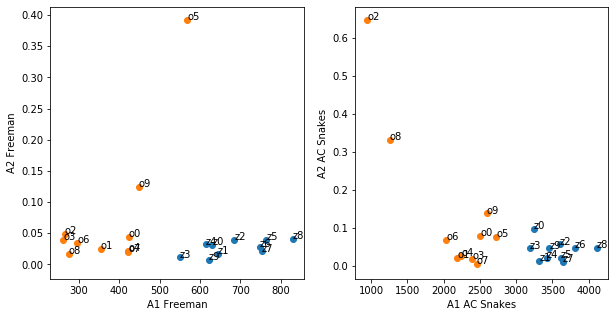

In [27]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0] = scatter_ax(ax[0], (f_zeros_a1, f_ones_a1), (f_zeros_a2, f_ones_a2), ('A1 Freeman', 'A2 Freeman'), ('z', 'o'))
ax[1] = scatter_ax(ax[1], (zeros_a1, ones_a1), (zeros_a2, ones_a2), ('A1 AC Snakes', 'A2 AC Snakes'), ('z', 'o'))
plt.show()

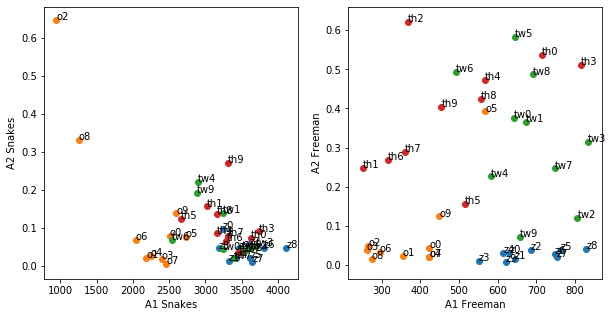

In [28]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0] = scatter_ax(ax[0], (zeros_a1, ones_a1, twos_a1, threes_a1),
                (zeros_a2, ones_a2, twos_a2, threes_a2),
                ('A1 Snakes', 'A2 Snakes'), ('z', 'o', 'tw', 'th'))

ax[1] = scatter_ax(ax[1], (f_zeros_a1, f_ones_a1, f_twos_a1, f_threes_a1),
                (f_zeros_a2, f_ones_a2, f_twos_a2, f_threes_a2),
                ('A1 Freeman', 'A2 Freeman'), ('z', 'o', 'tw', 'th'))
plt.show()

## Edit distance and compacity?

Defining the edit distance as the distance to a reference object.

In [29]:
from polyleven import levenshtein

def edit_dist_from_ref(ref, freeman_codes):
    n_classes = len(freeman_codes)
    ref_as_string = ''.join(ref.astype('str'))
    strings = [[''.join(f.astype('str')) for f in c] for c in freeman_codes]
    distances = [[levenshtein(d, ref_as_string) for d in arr] for arr in strings]
    return distances

In [30]:
def compacity(ims, freeman_codes, l_thr=150):
    perimeters = [[len(f) for f in c] for c in freeman_codes]
    areas = [[make_binary(i, l_thr, 255).sum() for i in im] for im in ims]
    compacities = [[p**2 / a for p, a in zip(per, ar)] for per, ar in zip(perimeters, areas)]
    return compacities

Using first zero no.6 as my reference.

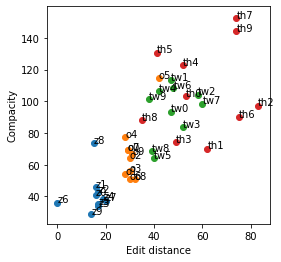

In [31]:
ref = zeros_freeman_codes[6]

zeros_d, ones_d, twos_d, threes_d = edit_dist_from_ref(ref, 
                                                       (zeros_freeman_codes, 
                                                       ones_freeman_codes, 
                                                       twos_freeman_codes, 
                                                       threes_freeman_codes))

zeros_c, ones_c, twos_c, threes_c = compacity((zeros_im, ones_im, twos_im, threes_im),
                                                       (zeros_freeman_codes, 
                                                       ones_freeman_codes, 
                                                       twos_freeman_codes, 
                                                       threes_freeman_codes))
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax = scatter_ax(ax, (zeros_d, ones_d, twos_d, threes_d),
                (zeros_c, ones_c, twos_c, threes_c),
                ('Edit distance', 'Compacity'), ('z', 'o', 'tw', 'th'))
plt.show()

Thought: Zeros and ones are quite easy to separate anyway with fourier descriptors. What if we try to choose a different reference for edit distance to try and separate twos and threes better?

Twos number 2 and 7 look like proper twos. 

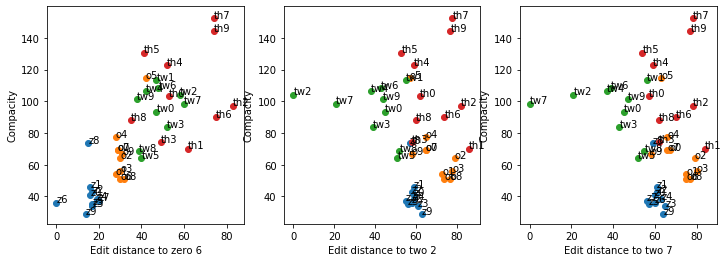

In [32]:
ref = twos_freeman_codes[2]

zeros_d22, ones_d22, twos_d22, threes_d22 = edit_dist_from_ref(ref, 
                                                       (zeros_freeman_codes, 
                                                       ones_freeman_codes, 
                                                       twos_freeman_codes, 
                                                       threes_freeman_codes))

ref = twos_freeman_codes[7]
zeros_d27, ones_d27, twos_d27, threes_d27 = edit_dist_from_ref(ref, 
                                                       (zeros_freeman_codes, 
                                                       ones_freeman_codes, 
                                                       twos_freeman_codes, 
                                                       threes_freeman_codes))


fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0] = scatter_ax(ax[0], (zeros_d, ones_d, twos_d, threes_d),
                (zeros_c, ones_c, twos_c, threes_c),
                ('Edit distance to zero 6', 'Compacity'), ('z', 'o', 'tw', 'th'))
ax[1] = scatter_ax(ax[1], (zeros_d22, ones_d22, twos_d22, threes_d22),
                (zeros_c, ones_c, twos_c, threes_c),
                ('Edit distance to two 2', 'Compacity'), ('z', 'o', 'tw', 'th'))
ax[2] = scatter_ax(ax[2], (zeros_d27, ones_d27, twos_d27, threes_d27),
                (zeros_c, ones_c, twos_c, threes_c),
                ('Edit distance to two 7', 'Compacity'), ('z', 'o', 'tw', 'th'))

plt.show()

The idea here is to pick typical representations of one class as a reference in order to pull the other members of that class towards 0 edit distance. If we, for instance, picked the atypical one number 5, it wouldn't do much separation. The other twos have been tried as well, but performed -as expected- worse, since they are more atypical for their class.

It's not very clear if two number 2 or 7 manages to pull the twos away from the threes more. Can a three do the trick?

Guessing first that three no 2 and 7 are good representatives.

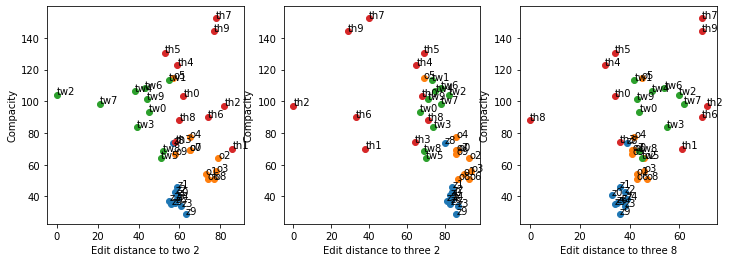

In [33]:
ref = threes_freeman_codes[2]

zeros_d32, ones_d32, twos_d32, threes_d32 = edit_dist_from_ref(ref, 
                                                       (zeros_freeman_codes, 
                                                       ones_freeman_codes, 
                                                       twos_freeman_codes, 
                                                       threes_freeman_codes))

ref = threes_freeman_codes[8]

zeros_d38, ones_d38, twos_d38, threes_d38 = edit_dist_from_ref(ref, 
                                                       (zeros_freeman_codes, 
                                                       ones_freeman_codes, 
                                                       twos_freeman_codes, 
                                                       threes_freeman_codes))


fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0] = scatter_ax(ax[0], (zeros_d22, ones_d22, twos_d22, threes_d22),
                (zeros_c, ones_c, twos_c, threes_c),
                ('Edit distance to two 2', 'Compacity'), ('z', 'o', 'tw', 'th'))
ax[1] = scatter_ax(ax[1], (zeros_d32, ones_d32, twos_d32, threes_d32),
                (zeros_c, ones_c, twos_c, threes_c),
                ('Edit distance to three 2', 'Compacity'), ('z', 'o', 'tw', 'th'))
ax[2] = scatter_ax(ax[2], (zeros_d38, ones_d38, twos_d38, threes_d38),
                (zeros_c, ones_c, twos_c, threes_c),
                ('Edit distance to three 8', 'Compacity'), ('z', 'o', 'tw', 'th'))

plt.show()

In favor of three 2 here. Most threes are closer to zero than is the case with three 8. Other threes have been tried with less success.

## Axes of Intertia

**Following cell** is fetched from [this](https://stackoverflow.com/questions/9005659/compute-eigenvectors-of-image-in-python) Stackoverflow thread.

In [35]:
def raw_moment(data, iord, jord):
    nrows, ncols = data.shape
    y, x = np.mgrid[:nrows, :ncols]
    data = data * x**iord * y**jord
    return data.sum()

def intertial_axis(data):
    'Calculate the x-mean, y-mean, and cov matrix of an image.'
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    
    x_bar = m10 / data_sum
    y_bar = m01 / data_sum
    
    u11 = (raw_moment(data, 1, 1) - x_bar * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_bar * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_bar * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])

    return x_bar, y_bar, cov

def plot_bars(x_bar, y_bar, cov, ax):
    'Plot bars with a length of 2 stddev along the principal axes.'
    def make_lines(eigvals, eigvecs, mean, i):
        """Make lines a length of 2 stddev."""
        std = np.sqrt(eigvals[i])
        vec = 2 * std * eigvecs[:,i] / np.hypot(*eigvecs[:,i])
        x, y = np.vstack((mean-vec, mean, mean+vec)).T
        return x, y
    mean = np.array([x_bar, y_bar])
    eigvals, eigvecs = np.linalg.eigh(cov)
    print(eigvals)
    ax.plot(*make_lines(eigvals, eigvecs, mean, 0), marker='o', color='white')
    ax.plot(*make_lines(eigvals, eigvecs, mean, -1), marker='o', color='red')
    ax.axis('image')

#### Test:

[ 4.35981376 38.0387727 ]


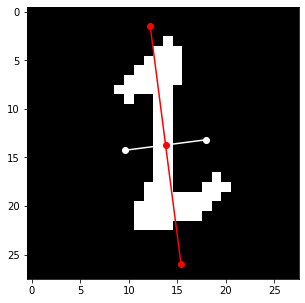

In [43]:
im = make_binary(ones_im[9], 150, 255)

x_bar, y_bar, cov = intertial_axis(im)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(im, cmap='gray')

plot_bars(x_bar, y_bar, cov, ax)
plt.show()

In [37]:
def ims_eigs(ims, l_thr=150):
    covs = [[intertial_axis(make_binary(i, l_thr, 255))[2] for i in im] for im in ims]
    eigs = [np.array([np.linalg.eig(c)[0] for c in cov]) for cov in covs]
    return eigs

In [38]:
eigs = ims_eigs((zeros_im, ones_im, twos_im, threes_im))

(zeros_eig1, zeros_eig2), (ones_eig1, ones_eig2), (twos_eig1, twos_eig2), (threes_eig1, threes_eig2) = [(e[:,0], 
                                                                                                         e[:,1]) 
                                                                                                        for e in eigs]

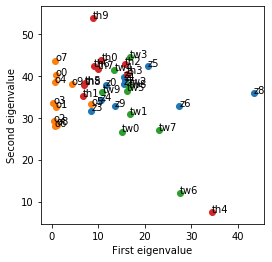

In [39]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax = scatter_ax(ax, (zeros_eig1, ones_eig1, twos_eig1, threes_eig1), 
                (zeros_eig2, ones_eig2, twos_eig2, threes_eig2),
                ('First eigenvalue', 'Second eigenvalue'), 
                ('z', 'o', 'tw', 'th'))
plt.show()

First eigenvalue seems to have some power to separate ones from the others. 

Second eigenvalue does not seem to discriminate anything very well.

Play around with what we have: Edit distance, fourier things and compacity

## First eigenvalue and others

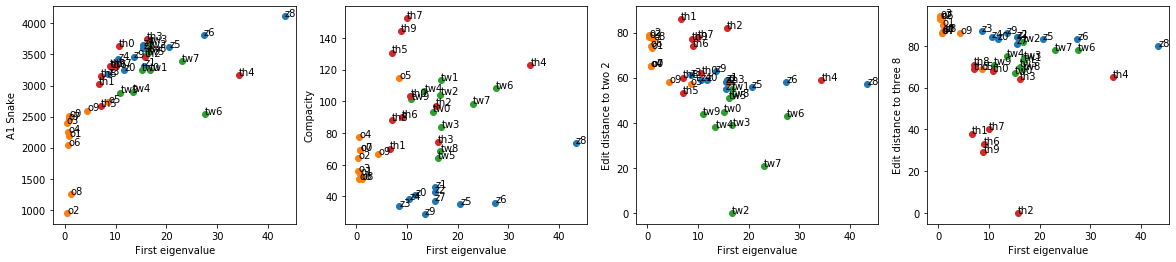

In [40]:
fig, ax = plt.subplots(1,4, figsize=(20,4))

ax[0] = scatter_ax(ax[0], (zeros_eig1, ones_eig1, twos_eig1, threes_eig1), 
                (zeros_a1, ones_a1, twos_a1, threes_a1),
                ('First eigenvalue', 'A1 Snake'), 
                ('z', 'o', 'tw', 'th'))

ax[1] = scatter_ax(ax[1], (zeros_eig1, ones_eig1, twos_eig1, threes_eig1), 
                (zeros_c, ones_c, twos_c, threes_c),
                ('First eigenvalue', 'Compacity'), 
                ('z', 'o', 'tw', 'th'))

ax[2] = scatter_ax(ax[2], (zeros_eig1, ones_eig1, twos_eig1, threes_eig1), 
                (zeros_d22, ones_d22, twos_d22, threes_d22),
                ('First eigenvalue', 'Edit distance to two 2'), 
                ('z', 'o', 'tw', 'th'))

ax[3] = scatter_ax(ax[3], (zeros_eig1, ones_eig1, twos_eig1, threes_eig1), 
                (zeros_d32, ones_d32, twos_d32, threes_d32),
                ('First eigenvalue', 'Edit distance to three 8'), 
                ('z', 'o', 'tw', 'th'))

plt.show()

## A1 and others

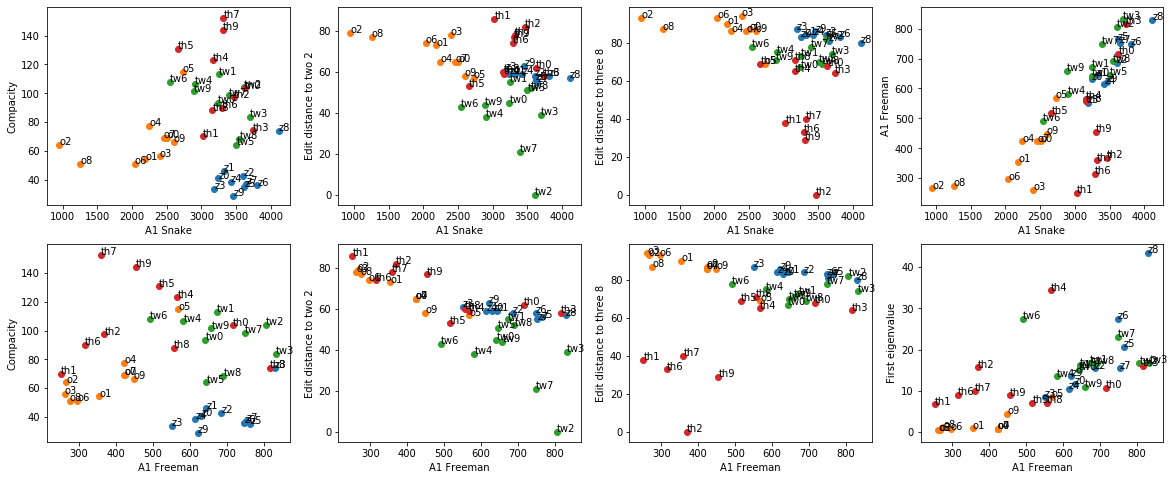

In [41]:
fig, ax = plt.subplots(2,4, figsize=(20,8))

ax[0,0] = scatter_ax(ax[0,0], (zeros_a1, ones_a1, twos_a1, threes_a1),
                (zeros_c, ones_c, twos_c, threes_c),
                ('A1 Snake', 'Compacity'), 
                ('z', 'o', 'tw', 'th'))

ax[0,1] = scatter_ax(ax[0,1], (zeros_a1, ones_a1, twos_a1, threes_a1),
                (zeros_d22, ones_d22, twos_d22, threes_d22),
                ('A1 Snake', 'Edit distance to two 2'), 
                ('z', 'o', 'tw', 'th'))

ax[0,2] = scatter_ax(ax[0,2], (zeros_a1, ones_a1, twos_a1, threes_a1),
                (zeros_d32, ones_d32, twos_d32, threes_d32),
                ('A1 Snake', 'Edit distance to three 8'), 
                ('z', 'o', 'tw', 'th'))

ax[0,3] = scatter_ax(ax[0,3], (zeros_a1, ones_a1, twos_a1, threes_a1),
                (f_zeros_a1, f_ones_a1, f_twos_a1, f_threes_a1),
                ('A1 Snake', 'A1 Freeman'), 
                ('z', 'o', 'tw', 'th'))

ax[1,0] = scatter_ax(ax[1,0], (f_zeros_a1, f_ones_a1, f_twos_a1, f_threes_a1),
                (zeros_c, ones_c, twos_c, threes_c),
                ('A1 Freeman', 'Compacity'), 
                ('z', 'o', 'tw', 'th'))

ax[1,1] = scatter_ax(ax[1,1], (f_zeros_a1, f_ones_a1, f_twos_a1, f_threes_a1),
                (zeros_d22, ones_d22, twos_d22, threes_d22),
                ('A1 Freeman', 'Edit distance to two 2'), 
                ('z', 'o', 'tw', 'th'))

ax[1,2] = scatter_ax(ax[1,2], (f_zeros_a1, f_ones_a1, f_twos_a1, f_threes_a1),
                (zeros_d32, ones_d32, twos_d32, threes_d32),
                ('A1 Freeman', 'Edit distance to three 8'), 
                ('z', 'o', 'tw', 'th'))

ax[1,3] = scatter_ax(ax[1,3], (f_zeros_a1, f_ones_a1, f_twos_a1, f_threes_a1),
                (zeros_eig1, ones_eig1, twos_eig1, threes_eig1),
                ('A1 Freeman', 'First eigenvalue'), 
                ('z', 'o', 'tw', 'th'))


plt.show()

Favorites: A1 Snakes, Edit distance to two 2 and three 8

## A2 and others

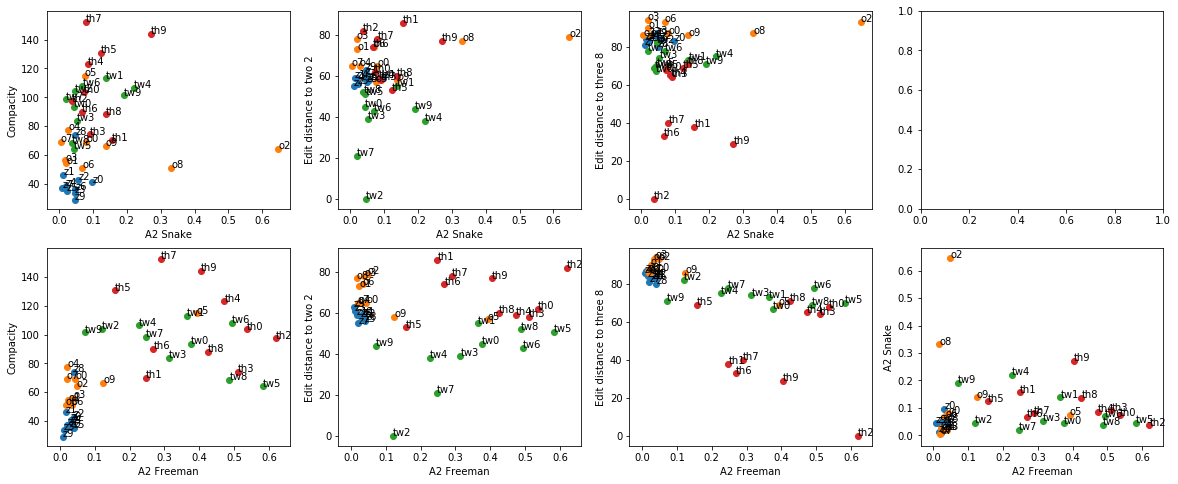

In [42]:
fig, ax = plt.subplots(2,4, figsize=(20,8))

ax[0,0] = scatter_ax(ax[0,0], (zeros_a2, ones_a2, twos_a2, threes_a2),
                (zeros_c, ones_c, twos_c, threes_c),
                ('A2 Snake', 'Compacity'), 
                ('z', 'o', 'tw', 'th'))

ax[0,1] = scatter_ax(ax[0,1], (zeros_a2, ones_a2, twos_a2, threes_a2),
                (zeros_d22, ones_d22, twos_d22, threes_d22),
                ('A2 Snake', 'Edit distance to two 2'), 
                ('z', 'o', 'tw', 'th'))

ax[0,2] = scatter_ax(ax[0,2], (zeros_a2, ones_a2, twos_a2, threes_a2),
                (zeros_d32, ones_d32, twos_d32, threes_d32),
                ('A2 Snake', 'Edit distance to three 8'), 
                ('z', 'o', 'tw', 'th'))

ax[1,0] = scatter_ax(ax[1,0], (f_zeros_a2, f_ones_a2, f_twos_a2, f_threes_a2),
                (zeros_c, ones_c, twos_c, threes_c),
                ('A2 Freeman', 'Compacity'), 
                ('z', 'o', 'tw', 'th'))

ax[1,1] = scatter_ax(ax[1,1], (f_zeros_a2, f_ones_a2, f_twos_a2, f_threes_a2),
                (zeros_d22, ones_d22, twos_d22, threes_d22),
                ('A2 Freeman', 'Edit distance to two 2'), 
                ('z', 'o', 'tw', 'th'))

ax[1,2] = scatter_ax(ax[1,2], (f_zeros_a2, f_ones_a2, f_twos_a2, f_threes_a2),
                (zeros_d32, ones_d32, twos_d32, threes_d32),
                ('A2 Freeman', 'Edit distance to three 8'), 
                ('z', 'o', 'tw', 'th'))


ax[1,3] = scatter_ax(ax[1,3], (f_zeros_a2, f_ones_a2, f_twos_a2, f_threes_a2),
                (zeros_a2, ones_a2, twos_a2, threes_a2),
                ('A2 Freeman', 'A2 Snake'), 
                ('z', 'o', 'tw', 'th'))
plt.show()

Observe: o5, o8, o2 are the only ones that differ.

## Chamfer distance and ...?

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here